In [1]:
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect

from apoNN.src.occam import Occam

import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections


from apoNN.src.datasets import ApogeeDataset,AspcapDataset

from apoNN.src.utils import generate_loss_with_masking
from apoNN.src.utils import dump
from apoNN.src.utils import load
import apoNN.src.vectors as vector

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA

from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
apogee_path.change_dr(16)

n_data=20000

[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


In [2]:
allStar =  load("allStar_training_clean")[:n_data]
dataset=  AspcapDataset(filename="aspcap_training_clean",tensor_type=torch.FloatTensor,recenter=True)


In [4]:
len(allStar)

20000

In [6]:
allStar[0]["Teff"]

5044.2817

In [7]:
allStar[1]["Teff"]

4687.1265

In [8]:
allStar[2]["Teff"]

4683.4907

In [24]:
len(allStar)

20000

In [26]:
ids = np.arange(len(allStar))
kept_ids = np.delete(ids,[2,5,8])

In [27]:
len(allStar[ids])

19997

In [74]:
upper_temp_cut = allStar["Teff"]<5500
lower_temp_cut = allStar["Teff"]>4000
lower_g_cut = allStar["logg"]>1.
upper_g_cut = allStar["logg"]<3.5
snr_cut = allStar["SNR"]>300
snr_highcut = allStar["SNR"]<500
feh_outliercut = allStar["Fe_H"]>-5
c_outliercut = allStar["C_FE"]>-5
n_outliercut = allStar["n_fe"]>-5
o_outliercut = allStar["O_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
k_outliercut = allStar["k_fe"]>-5
ca_outliercut = allStar["ca_fe"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5
mn_outliercut = allStar["mn_fe"]>-5
co_outliercut = allStar["co_fe"]>-5
n_outliercut = allStar["n_fe"]>-5
ni_outliercut = allStar["ni_fe"]>-5
cu_outliercut = allStar["cu_fe"]>-5
aspcapflag = allStar["ASPCAPFLAG"]==0
starflag = allStar["starflag"]==0
vscatter_cut = allStar["VSCATTER"]<1

combined_cut = vscatter_cut & aspcapflag & starflag & lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut & snr_cut & snr_highcut & feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut & ca_outliercut & n_outliercut & mn_outliercut & k_outliercut & co_outliercut & ni_outliercut & cu_outliercut


In [75]:
considered_parameters = ["Fe_H","O_FE","C_FE","Ca_FE","Ti_Fe","N_FE","K_FE","Mn_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE","CO_FE","CU_FE"] 
y = vector.Vector(np.array([allStar[combined_cut][param] for param in considered_parameters])[:,:n_data].T)

In [76]:
len(y.raw)

4368

In [50]:
y.normalized.shape

(9267, 17)

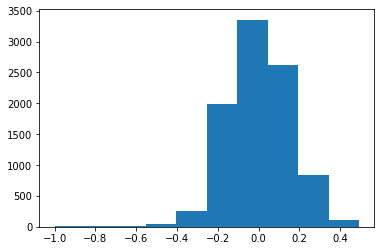

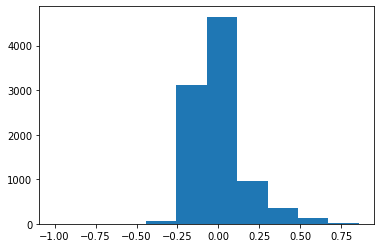

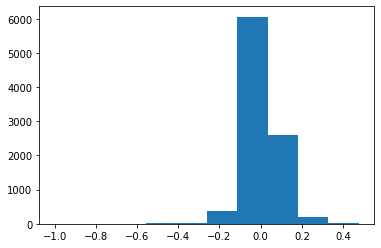

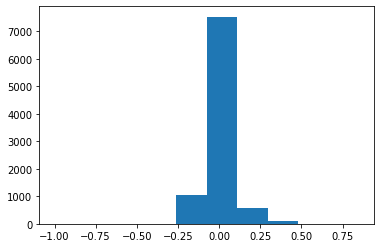

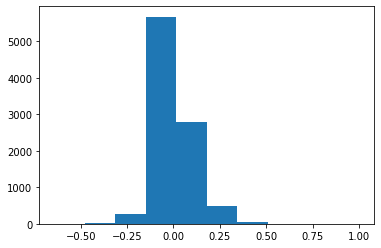

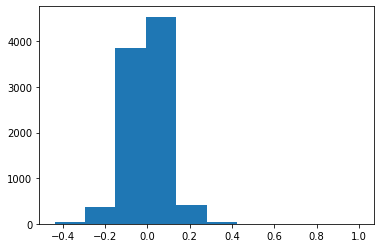

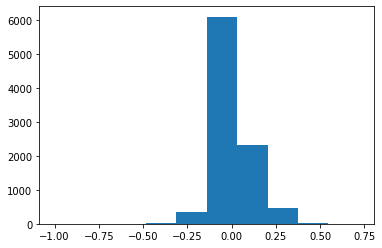

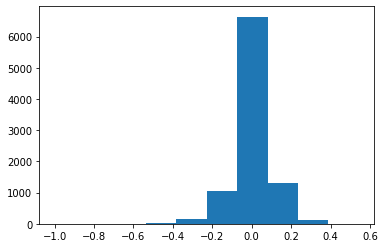

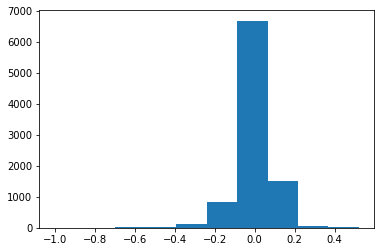

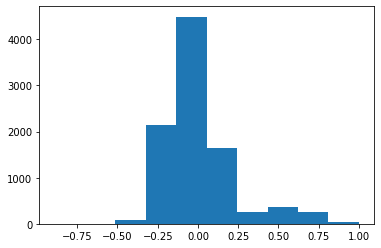

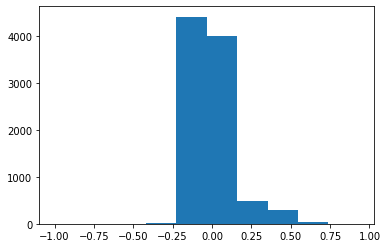

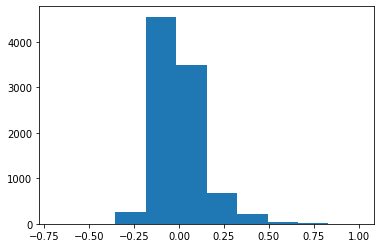

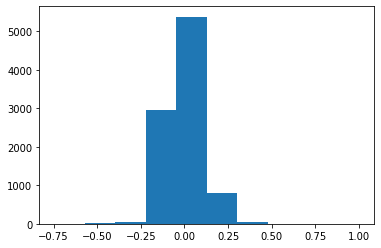

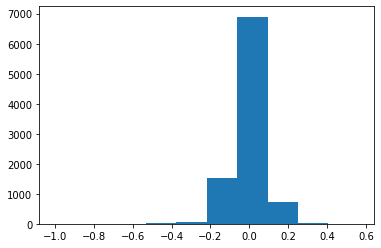

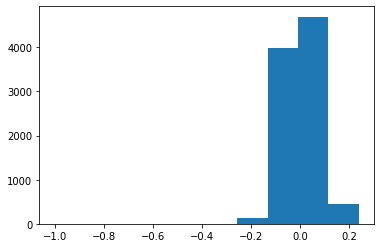

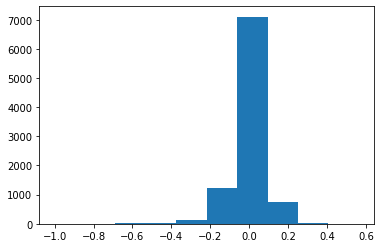

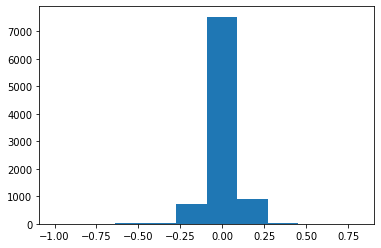

In [51]:
for i in range(y.raw.shape[1]):
    plt.hist(y.normalized[:,i])
    plt.show()

In [7]:
n_bins = len(dataset[0][0])
activation= torch.nn.SELU()
lr = 0.0001
encoder_architecture = [n_bins,4096,1024,512,y.raw.shape[1]]
encoder = Feedforward(encoder_architecture ,activation=activation).to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)


In [8]:
loss = torch.nn.MSELoss()

In [5]:
x = dataset.dataset["aspcap"][combined_cut]


In [10]:
n_batch=64
idx_loader = torch.utils.data.DataLoader(np.arange(x.shape[0]),batch_size=100)


In [11]:
for epoch in range(100000):
    for idx in idx_loader:
        optimizer.zero_grad()
        spec = torch.tensor(x[idx.numpy()]).to(device)
        y_val = torch.tensor(y.normalized[idx.numpy()]).to(device)
        y_pred = encoder(spec.to(device))
        err = loss(y_pred,y_val)
        err.backward()
        optimizer.step()
    print(f"err:{err}")



err:0.010621135123074055
err:0.010536757297813892
err:0.009696165099740028
err:0.009131663478910923
err:0.007125162053853273
err:0.007207298651337624
err:0.009895249269902706
err:0.008227202109992504
err:0.009472991339862347
err:0.009303783997893333
err:0.008335776627063751
err:0.00851632934063673
err:0.00758751155808568
err:0.008072774857282639
err:0.00668955547735095
err:0.006571627222001553
err:0.006497115828096867
err:0.0070211379788815975
err:0.006595171056687832
err:0.006249119993299246
err:0.006019194610416889
err:0.00615872023627162
err:0.0058406502939760685
err:0.005252792499959469
err:0.005663852207362652
err:0.0054977769032120705
err:0.005185127258300781
err:0.005293511785566807
err:0.0052067916840314865
err:0.005746159236878157
err:0.005098957568407059
err:0.004517174791544676
err:0.005300728138536215
err:0.004922221414744854
err:0.0049045211635529995
err:0.0043153660371899605
err:0.0045490325428545475
err:0.004213374573737383
err:0.00393156660720706
err:0.00405787117779254

KeyboardInterrupt: 

In [19]:
training_loss = []
for epoch in range(100000):
    if i%500==0:
        torch.save(autoencoder,f"ae_{epoch}.p")
        with open("training_loss.p","wb") as f:
            pickle.dump(training_loss, f)
        
    for idx in idx_loader:
        #print(i)
        optimizer.zero_grad()
        spec = torch.tensor(x[idx.numpy()]).to(device)
        y_val = torch.tensor(y.normalized[idx.numpy()]).to(device)
        y_pred = encoder(spec.to(device))
        err = loss(y_pred,y_val)
        err.backward()
        optimizer.step()
    training_loss.append(err.item())
    print(f"err:{err}")



err:0.00269113015383482
err:0.003016937058418989
err:0.002489230828359723
err:0.003133508376777172
err:0.0022641567047685385
err:0.0025100423954427242
err:0.0021932139061391354
err:0.002654280513525009
err:0.0021191821433603764
err:0.0021583246998488903
err:0.002467135200276971
err:0.002333142329007387
err:0.0024688751436769962
err:0.002035484416410327
err:0.0021022288128733635
err:0.002259813481941819
err:0.0023227271158248186
err:0.0022294006776064634


KeyboardInterrupt: 

In [22]:
import pickle
with open("training_loss.p","wb") as f:
    pickle.dump(training_loss, f)

In [ ]:
torch.save(encoder,"encoder.p")

In [17]:
x.shape[0]

14055

In [ ]:
y_pred = encoder(torch.tensor(dataset.dataset["aspcap"][combined_cut]).to(device)).detach().cpu().numpy()


In [ ]:
for i in range(y_pred.shape[1]):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(y_pred[:5000,i]-y.normalized[:5000,i])
    plt.scatter(y_pred[:5000,i],y.normalized[:5000,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.legend()
    plt.show()

In [ ]:
for i in range(y_pred.shape[1]):
    plt.title(considered_parameters[i])
    plt.scatter(y_pred[:,2],y_pred[:,i],s=0.5,alpha=0.5)
    plt.scatter(y.normalized[:,2],y.normalized[:,i],s=0.5,alpha=0.5,label="real")
    plt.legend()

    plt.show()

In [ ]:
i=11
plt.title(considered_parameters[i])
plt.scatter(y.normalized[:2243,2],y.normalized[:2243,i],s=0.5,alpha=0.5,label="real")


In [ ]:
i=12
plt.title(considered_parameters[i])
plt.scatter(y_pred[:2243,2],y_pred[:2243,i],s=0.5,alpha=0.5)


In [ ]:
considered_parameters[-5]

In [ ]:
plt.scatter(y_pred[:,10],y_pred[:,-5],s=0.5,alpha=0.5)


In [ ]:
plt.scatter(y.normalized[:,8],y.normalized[:,-5],s=0.5,alpha=0.5,label="real")


## Visualizing results

In [34]:
import pickle
with open("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/window/training_loss.p","rb") as f:
    training_loss = pickle.load(f)
training_loss = np.array(training_loss)

In [29]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

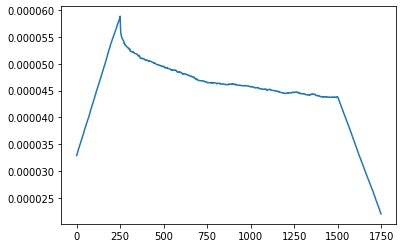

In [36]:
plt.plot(smooth(training_loss[0:],500))

In [8]:
encoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/raw/e_8000.p")

In [77]:
considered_parameters = ["Fe_H","O_FE","C_FE","Ca_FE","Ti_Fe","N_FE","K_FE","Mn_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE","CO_FE"] 
y = vector.Vector(np.array([allStar[combined_cut][param] for param in considered_parameters])[:,:n_data].T)

In [78]:
x = dataset.x[combined_cut] 
y_pred = vector.Vector(encoder(torch.tensor(x).to(device)).detach().cpu().numpy())

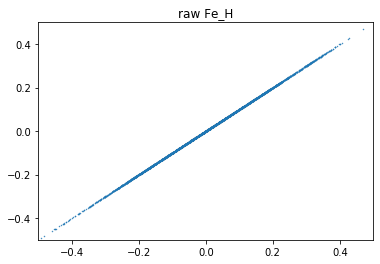

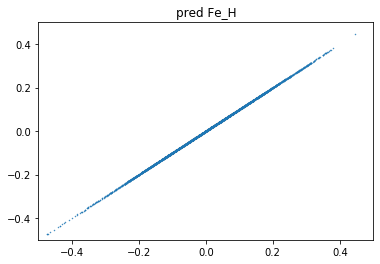

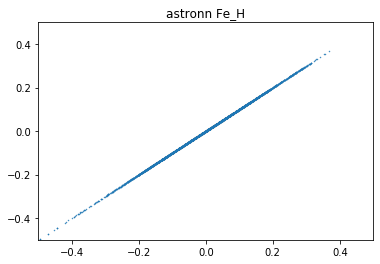

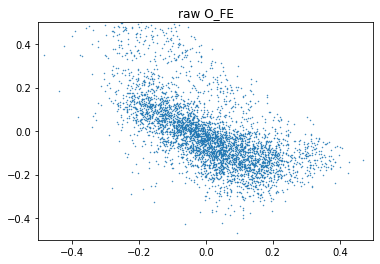

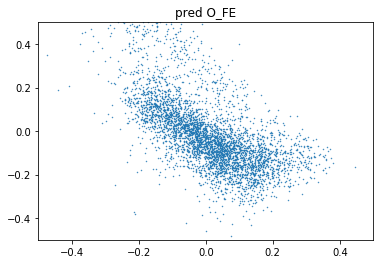

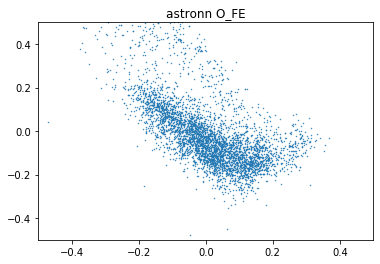

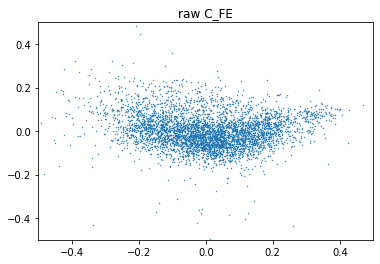

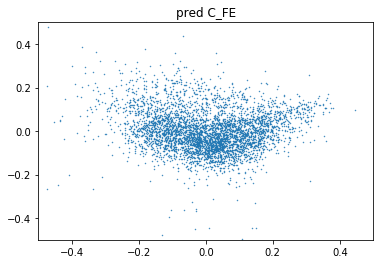

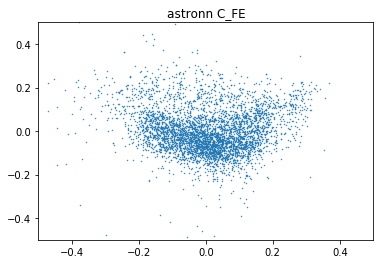

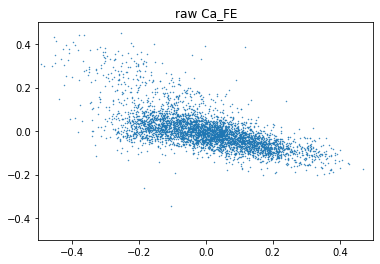

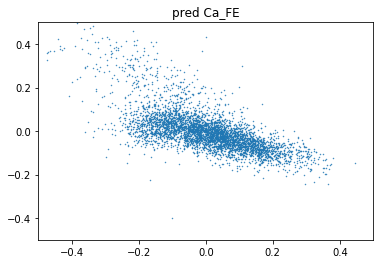

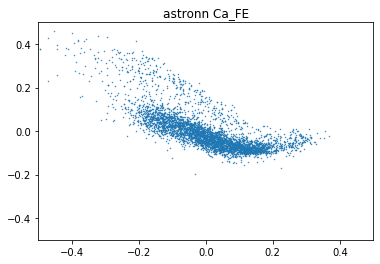

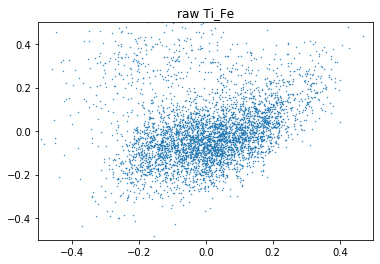

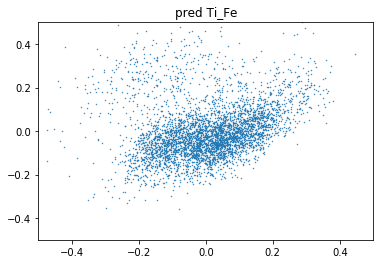

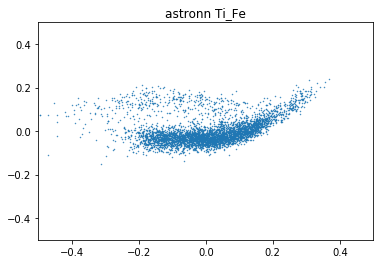

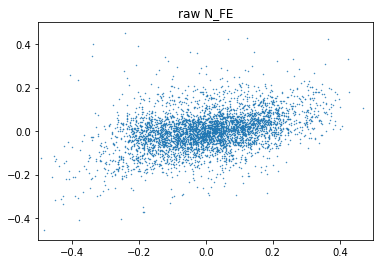

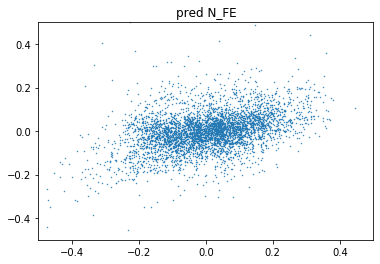

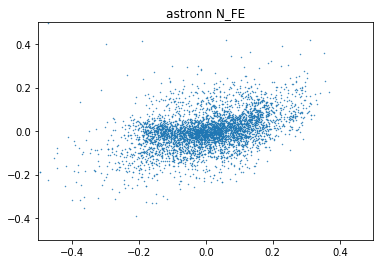

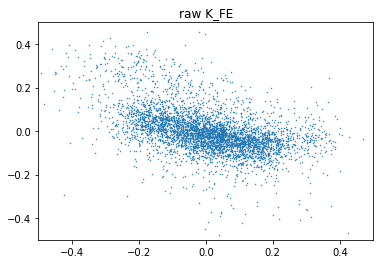

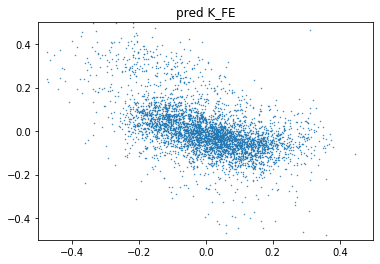

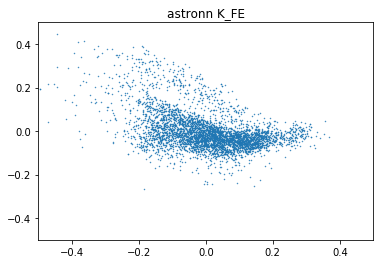

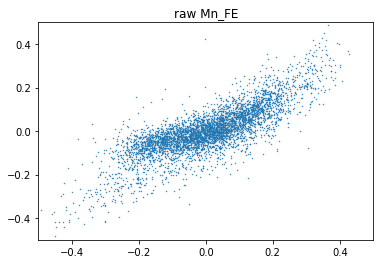

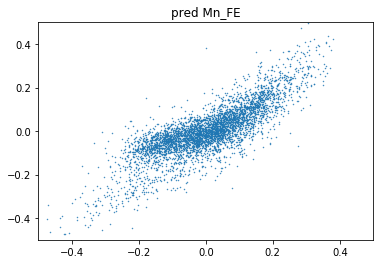

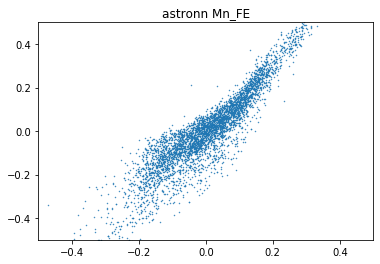

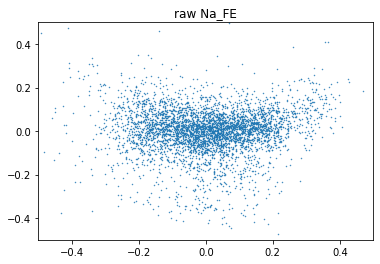

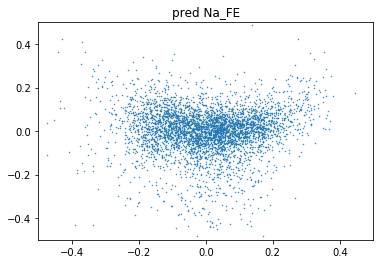

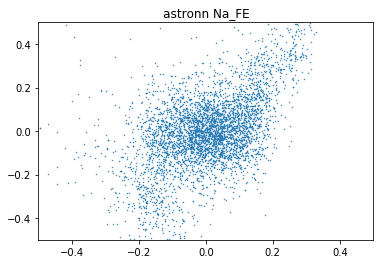

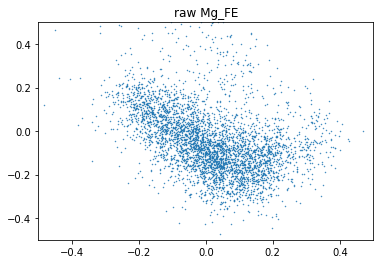

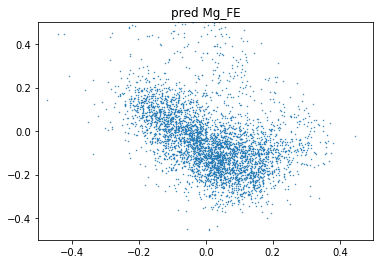

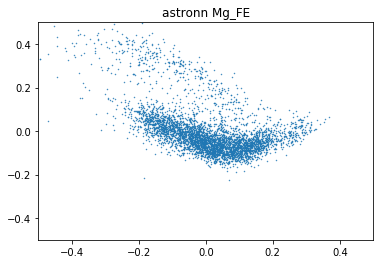

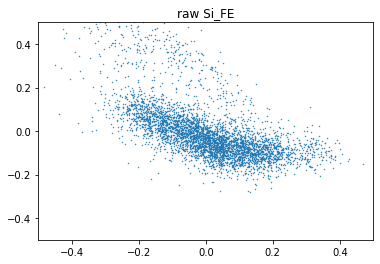

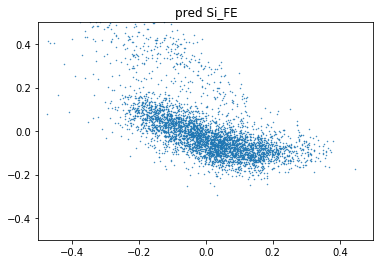

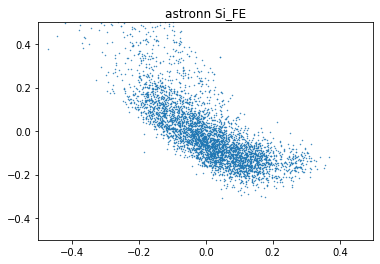

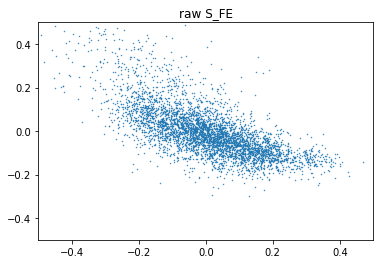

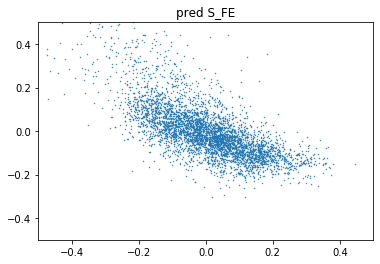

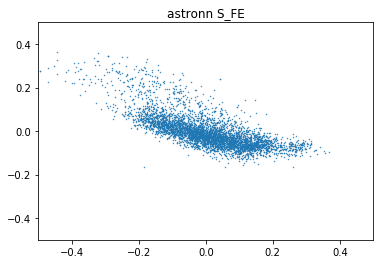

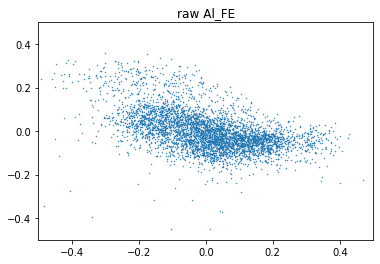

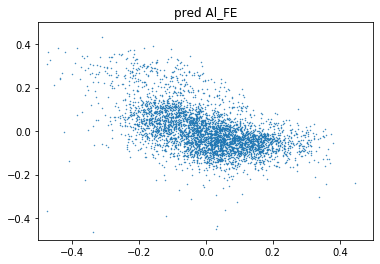

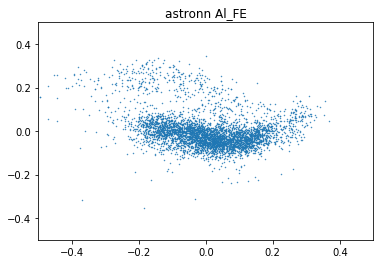

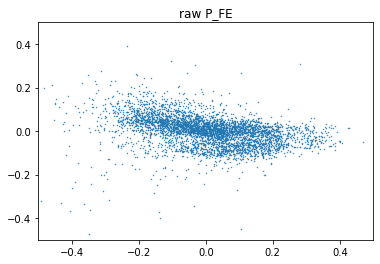

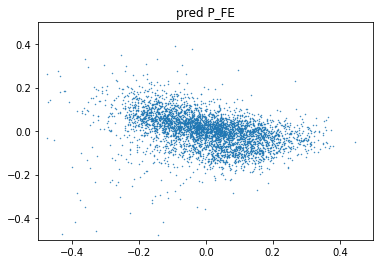

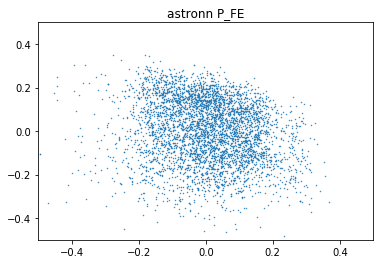

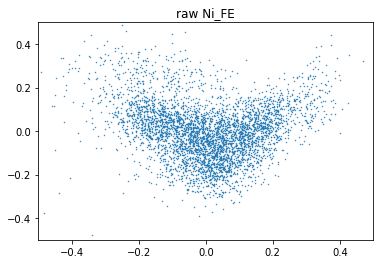

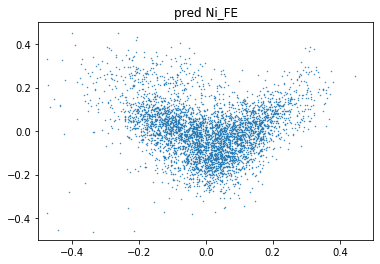

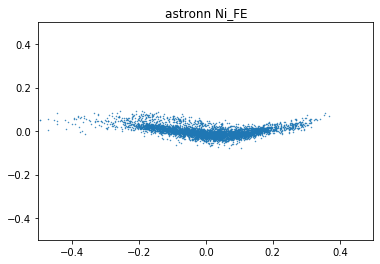

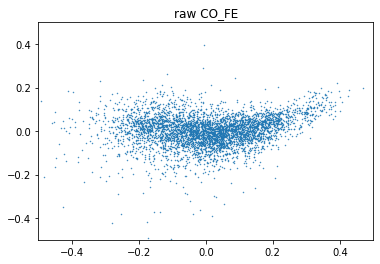

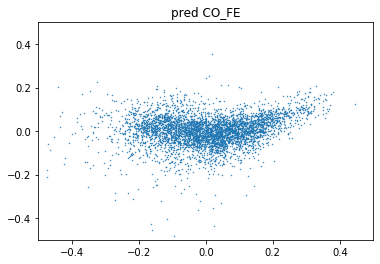

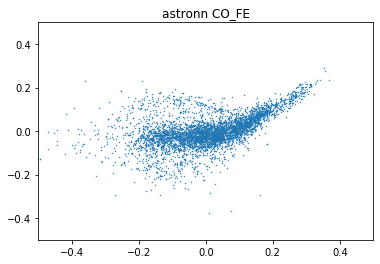

In [80]:
for i in range(len(considered_parameters)):
    plt.title(f"raw {considered_parameters[i]}")
    plt.scatter(y.normalized[:,0],y.normalized[:,i],s=0.2)
    plt.xlim(-0.5,0.5)
    plt.ylim(-0.5,0.5)

    plt.show()
    plt.title(f"pred {considered_parameters[i]}")
    plt.scatter(y_pred.normalized[:,0],y_pred.normalized[:,i],s=0.2)
    plt.xlim(-0.5,0.5)
    plt.ylim(-0.5,0.5)

    plt.show()
    plt.title(f"astronn {considered_parameters[i]}")
    plt.scatter(y_astronn.normalized[:,0],y_astronn.normalized[:,i],s=0.2)
    plt.xlim(-0.5,0.5)
    plt.ylim(-0.5,0.5)

    plt.show()

In [79]:
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)

In [63]:
len(y_astronn.raw)

9267

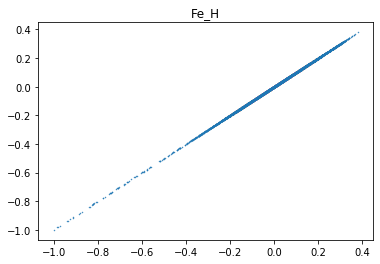

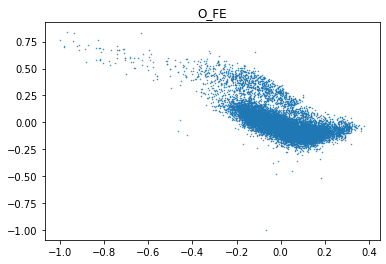

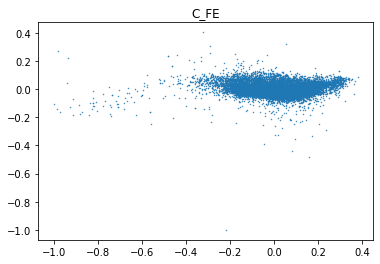

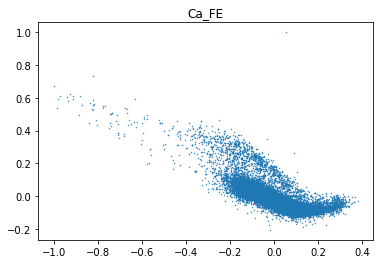

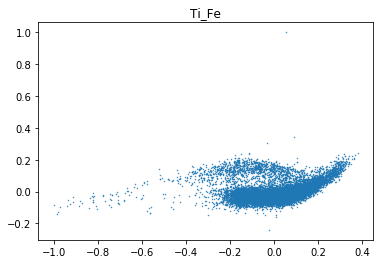

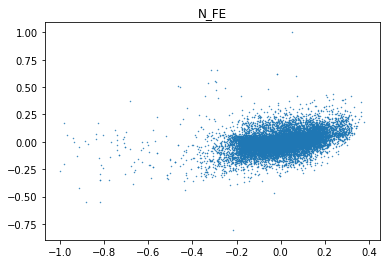

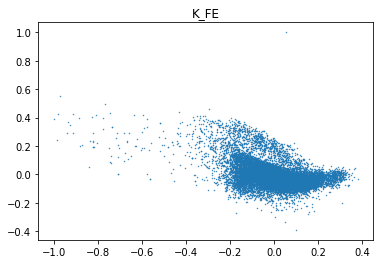

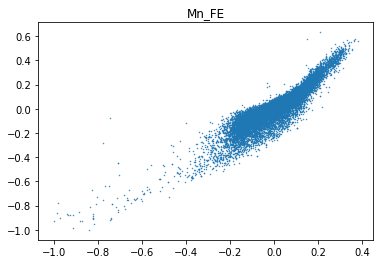

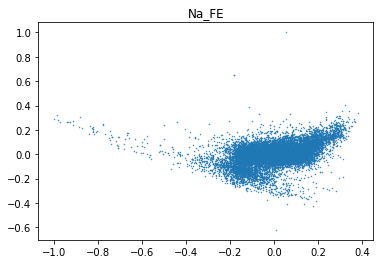

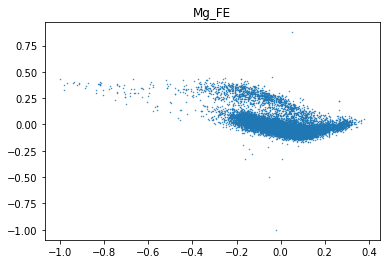

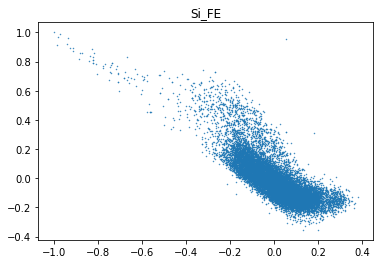

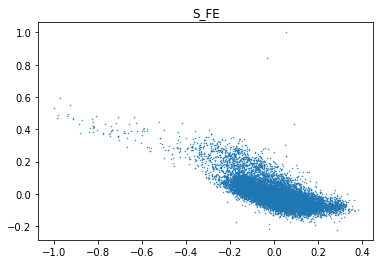

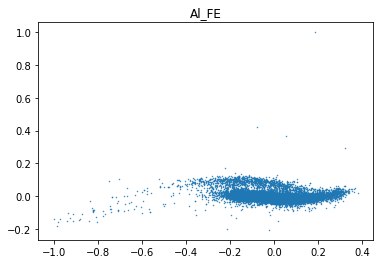

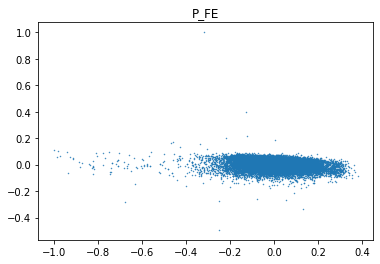

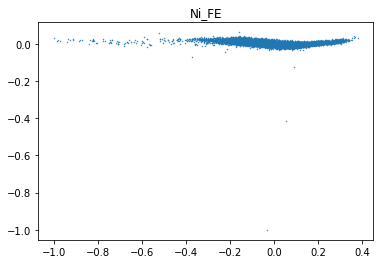

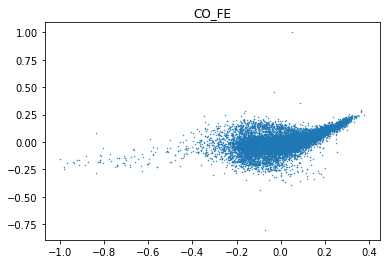

In [71]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    plt.scatter(y_astronn.normalized[:,0],y_astronn.normalized[:,i],s=0.2)
    plt.show()

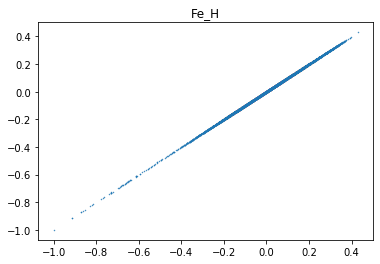

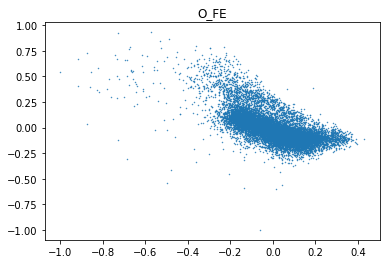

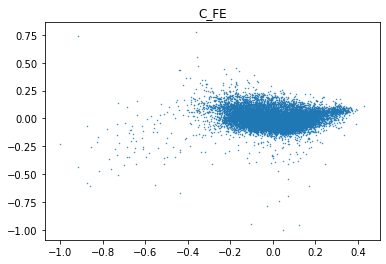

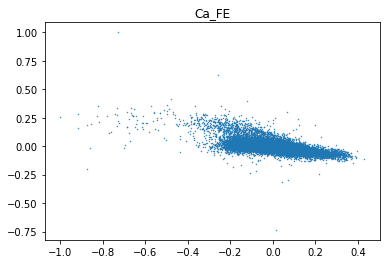

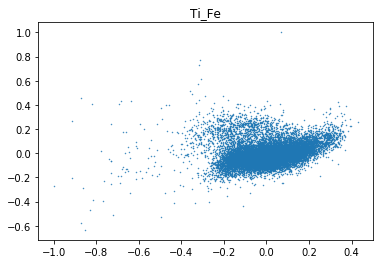

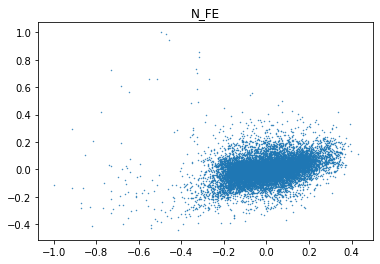

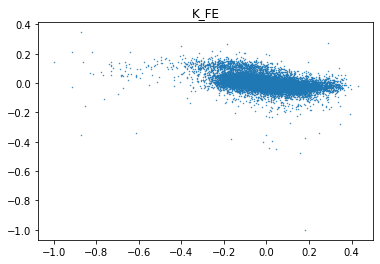

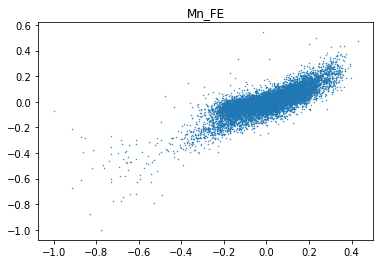

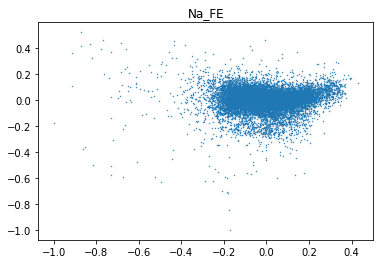

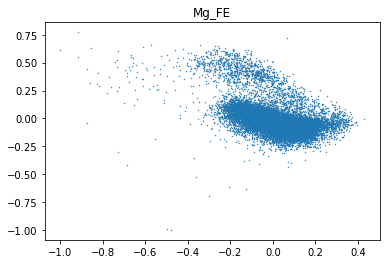

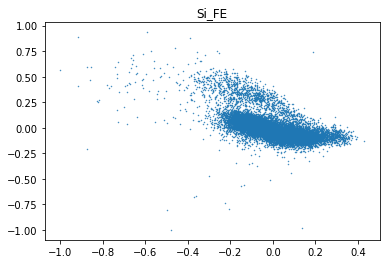

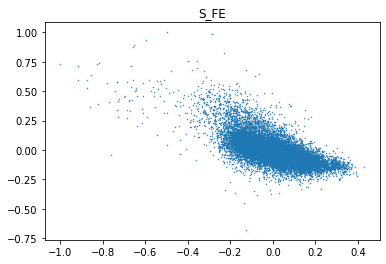

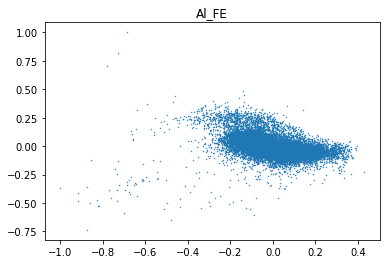

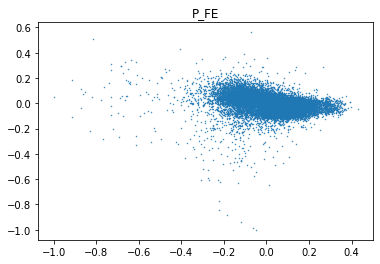

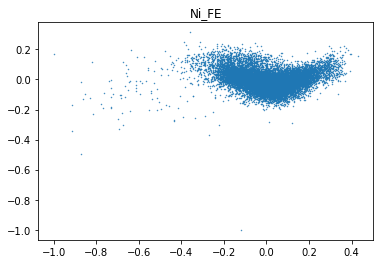

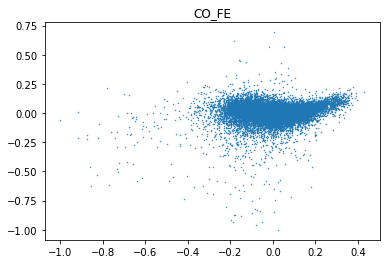

In [64]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    plt.scatter(y.normalized[:,0],y.normalized[:,i],s=0.2)

    plt.show()

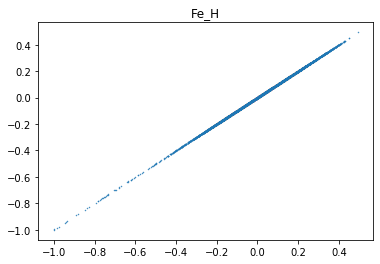

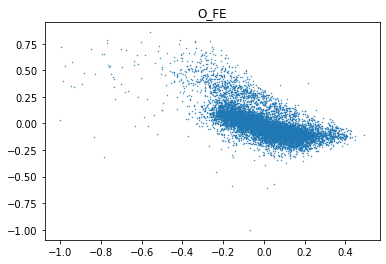

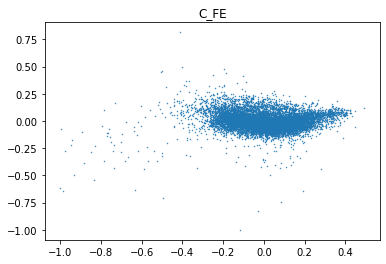

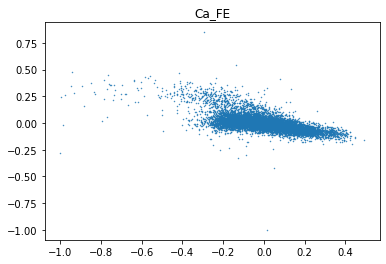

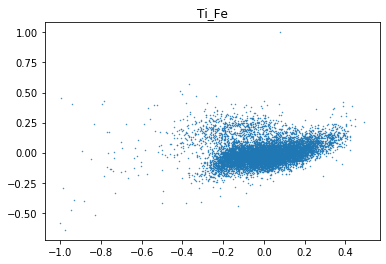

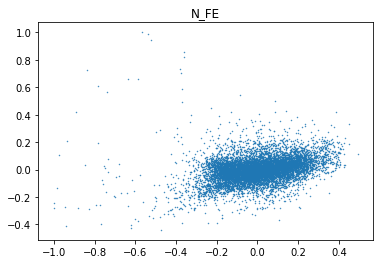

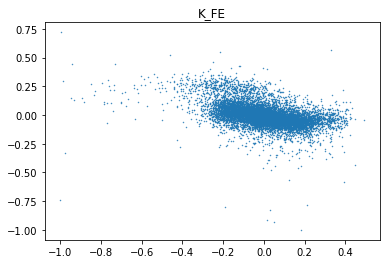

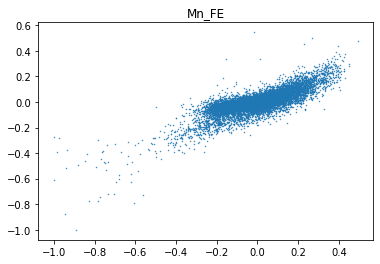

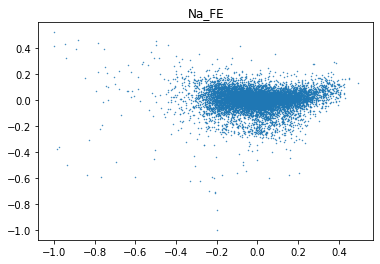

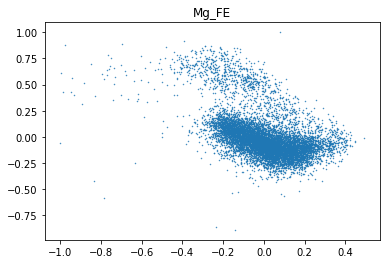

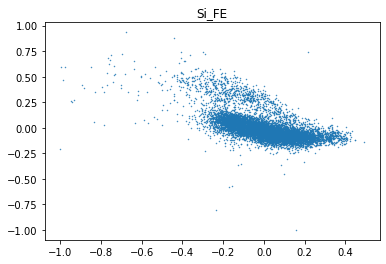

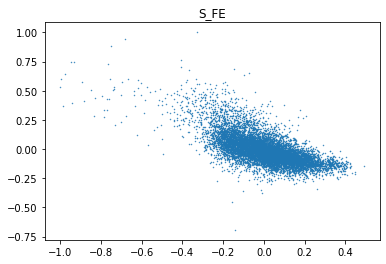

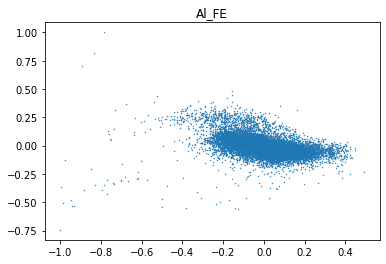

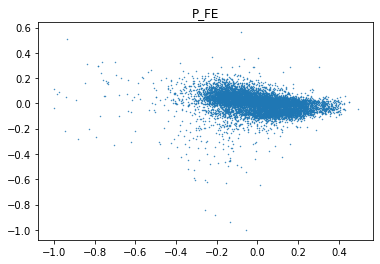

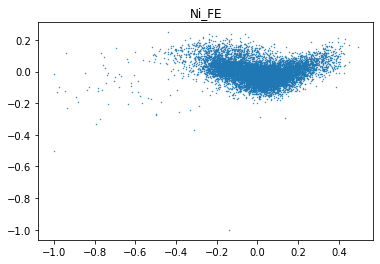

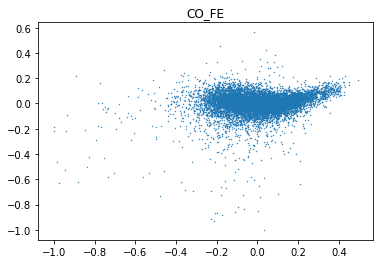

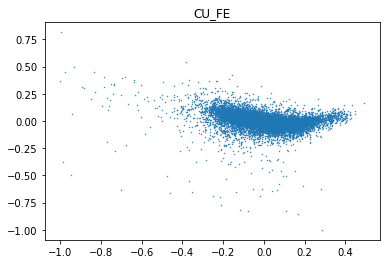

In [33]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    plt.scatter(y.normalized[:,0],y.normalized[:,i],s=0.2)

    plt.show()

In [24]:
np.sum(allStar["ASPCAPFLAG"]!=0)

275

In [28]:
np.sum(allStar["STARFLAG"]!=0)

6590

In [29]:
allStar["ASPCAPFLAG"]==0

array([ True,  True,  True, ...,  True,  True,  True])

In [84]:
np.sum(allStar["Commiss"]!=0)

0